# Regularización por ruido y _Dropout_

Las redes neuronales, y sobre todo las convolucionales (CNN), son muy susceptibles al sobreajuste. El **sobreajuste** es un problema de generalización donde las redes neuronales aprenden y reconocen todas las propiedades del conjunto de prueba, sin embargo cuando son evaluadas en datos que han observado tienen una muy baja precisión de reconocimiento.

Esto se debe a que las redes neuronales _memorizan_ o reconocen solamente las características del conjunto de prueba. A lo largo de los años los científicos han trabajado en mitigar este problema y han surgido dos metodologías que serán presentadas en este documento; existen muchas más metodologías que serán cubiertas en otros documentos.

## Regularización por ruido

Siguiendo un [artículo](https://eprint.iacr.org/2018/1023.pdf) y el [libro de Deep Learning](http://www.deeplearningbook.org/) se propone utilizar ruido como una forma de **regularización**, esto es, una forma de mitigar el sobreajuste de las redes neuronales.

El propósito del ruido es aplicar y añadir valores muestreados de una distribución normal a la entrada, salida o dentro de las capas escondidas de las redes neuronales. El resultado de esto es que se añade un término de regularización a la función de pérdida a minimizar, lo que provoca que la red neuronal sea más robusta a valores atípicos.

## _Dropout_

Uno de los métodos más revolucionarios en la historia del Deep Learning es el [artículo sobre Dropout](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer). La idea detrás de este método es bastante simple: escoger aleatoriamente un subconjunto de unidades conectadas dentro de la red neuronal en cuestión, y evaluar muchas veces sobre diferentes subconjuntos. Esto crea un estimado muy robusto sobre los datos evaluados dado que se está haciendo una especie de _promedio_ sobre diferentes redes neuronales, lo mejor de esto es que esto no tiene efecto sobre el cálculo adicional de parámetros.

Este método ha sido tan revolucionario que muchas de las arquitecturas más poderosas y eficientes lo utilizan, hasta el momento en que surgió _Batch Normalization,_ sin embargo sigue siendo uno de los métodos básicos para mitigar el sobreajuste en CNN. En este documento se demostrará su eficacia al ser comparado con la regularización por ruido.

In [27]:
from keras.datasets import fashion_mnist
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, GaussianNoise
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD
import matplotlib.pyplot as plt

## Fashion-MNIST

El conjunto de datos empleado es el [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) que tiene 10 clases, cada una pertenece a un tipo de prenda o de calzado. La idea de este conjunto de datos (en realidad son imágenes) es que sirva como un reemplazo para el famoso conjunto de datos de dígitos escritos a mano del MNIST.

Las imágenes tienen un tamaño de $28 \times 28$ y están en tono de grises.

In [28]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [29]:
# Tamaño de lote para el optimizador
batch_size = 128
# Número de clases, ya se sabe por que se conoce el conjunto de datos
# pero si no, se puede hacer de forma programática
num_classes = 10
# Número de épocas, dejar como está porque es suficiente
epocas = 50

# Tamaño de las imágenes, ancho y alto
img_rows, img_cols = 28, 28

In [30]:
# Para verificar el tamaño de las imágenes y el número de imágenes
x_train.shape

(60000, 28, 28)

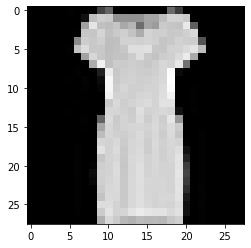

In [31]:
# Se puede visualizar una de estas imágenes para conocer el conjunto de datos
plt.imshow(x_train[20, :, :], cmap="gray")

Por ejemplo, en este caso se muestra un ejemplo de un _vestido,_ una de las 10 clases del conjunto de datos con el que se está trabajando.

In [32]:
# Reajustar las imágenes para asegurar que solamente es un canal de color
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# Tamaño de la entrada, en forma de tupla siempre
input_shape = (img_rows, img_cols, 1)

In [33]:
# Convertir a float32 para mejor manejo
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
# Normalizar los valores de las imágenes
x_train /= 255
x_test /= 255

In [34]:
print("Tamaño del conjunto de entrenamiento:", x_train.shape)
print(x_train.shape[0], "Muestras de entrenamiento")
print(x_test.shape[0], "Muestras de prueba")

Tamaño del conjunto de entrenamiento: (60000, 28, 28, 1)
60000 Muestras de entrenamiento
10000 Muestras de prueba


In [35]:
# Codificación One Hot para las etiquetas
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Arquitecturas de las CNN

Todas las arquitecturas tienen la misma forma en común, que proviene del [ejemplo de `keras`](https://keras.io/examples/cifar10_cnn/) para la clasificación del conjunto de datos CIFAR-10, solamente que en este caso se emplea otro conjunto de datos como ya se ha mostrado.

Sin embargo, para cada caso se modificará la arquitectura, específicamente:

1. **Ruido en la entrada:** Cuando las imágenes entren a la CNN se les agregará ruido gaussiano, muestreado de una distribución normal con media $\mu = 0.0$ y desviación estándar $\sigma^2 = 0.01$.

2. **Ruido en las capas escondidas:** Las imágenes entrarán a la CNN de forma normal, pero antes de cada función de activación existirá un aplicación de ruido gaussiano, muestreado de una distribución normal con media $\mu = 0.0$ y desviación estándar $\sigma^2 = 0.01$.

3. **Dropout:** Se aplicará _dropout_ después de cada etapa de extracción de características, esto es cuando se ha aplicado _pooling,_ y al final de la capa totalmente conectada. Para la parte de características, se escoge el 25% de unidades dentro de la capa, mientras que para la capa totalmente conectada se escogen 50% del total de las unidades.

In [36]:
# La entrada de la red tiene ruido solamente
arquitectura_ruido_entrada = [
    GaussianNoise(0.01, input_shape=x_train.shape[1:]),
    # Capa de entrada, primera capa de características
    Conv2D(32, kernel_size=(3, 3), padding="same"),
    Activation("relu"),
    Conv2D(32, (3, 3)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Segunda capa de características
    Conv2D(64, kernel_size=(3, 3), padding="same"),
    Activation("relu"),
    Conv2D(64, (3, 3)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Capa totalmente conectada
    Flatten(),
    Dense(512),
    Activation("relu"),
    # Capa de salida
    Dense(num_classes, activation="softmax")
]

In [37]:
# Las capas escondidas tienen ruido
arquitectura_ruido_capas = [
    # Capa de entrada, primera capa de características
    Conv2D(32, kernel_size=(3, 3),
           padding="same",
           input_shape=x_train.shape[1:]),
    GaussianNoise(0.01),
    Activation("relu"),
    Conv2D(32, (3, 3)),
    GaussianNoise(0.01),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Segunda capa de características
    Conv2D(64, kernel_size=(3, 3), padding="same"),
    GaussianNoise(0.01),
    Activation("relu"),
    Conv2D(64, (3, 3)),
    GaussianNoise(0.01),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Capa totalmente conectada
    Flatten(),
    Dense(512),
    GaussianNoise(0.01),
    Activation("relu"),
    # Capa de salida
    Dense(num_classes, activation="softmax")
]

In [38]:
# Se aplica dropout al final de cada capa de características y en la
# capa totalmente conectada
arquitectura_dropout = [
    # Capa de entrada, primera capa de características
    Conv2D(32, kernel_size=(3, 3),
           padding="same",
           input_shape=x_train.shape[1:]),
    Activation("relu"),
    Conv2D(32, (3, 3)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Segunda capa de características
    Conv2D(64, kernel_size=(3, 3), padding="same"),
    Activation("relu"),
    Conv2D(64, (3, 3)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Capa totalmente conectada
    Flatten(),
    Dense(512),
    Dropout(0.5),
    Activation("relu"),
    # Capa de salida
    Dense(num_classes, activation="softmax")
]

In [39]:
# Se construyen los modelos con esta arquitectura
modelo_dropout = Sequential(arquitectura_dropout)
modelo_ruido_entrada = Sequential(arquitectura_ruido_entrada)
modelo_ruido_capas = Sequential(arquitectura_ruido_capas)

### Ruido a la entrada

En esta parte se emplea el modelo que tiene ruido a la entrada de la CNN. El optimizador utilizado es el muy robusto y clásico descenso de gradiente estocástico, con un ratio de aprendizaje de 0.001 y momento de 0.9, para acelerar el aprendizaje.

In [40]:
modelo_ruido_entrada.compile(loss="categorical_crossentropy",
                            optimizer=SGD(lr=0.001, momentum=0.9),
                            metrics=["accuracy"])
historia_ruido_entrada = modelo_ruido_entrada.fit(x_train, y_train, batch_size=batch_size,
                        validation_split=0.2,
                        epochs=epocas)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 67s 1ms/step - loss: 1.4584 - acc: 0.4689 - val_loss: 0.7579 - val_acc: 0.7074
Epoch 2/50
48000/48000 [==============================] - 59s 1ms/step - loss: 0.6495 - acc: 0.7605 - val_loss: 0.6240 - val_acc: 0.7590
Epoch 3/50
48000/48000 [==============================] - 58s 1ms/step - loss: 0.5406 - acc: 0.8025 - val_loss: 0.5410 - val_acc: 0.7962
Epoch 4/50
48000/48000 [==============================] - 57s 1ms/step - loss: 0.4845 - acc: 0.8249 - val_loss: 0.4748 - val_acc: 0.8295
Epoch 5/50
48000/48000 [==============================] - 61s 1ms/step - loss: 0.4526 - acc: 0.8379 - val_loss: 0.4512 - val_acc: 0.8396
Epoch 6/50
48000/48000 [==============================] - 61s 1ms/step - loss: 0.4288 - acc: 0.8484 - val_loss: 0.4208 - val_acc: 0.8515
Epoch 7/50
48000/48000 [==============================] - 63s 1ms/step - loss: 0.4032 - acc: 0.8552 - val_loss: 0.4118 - val_acc

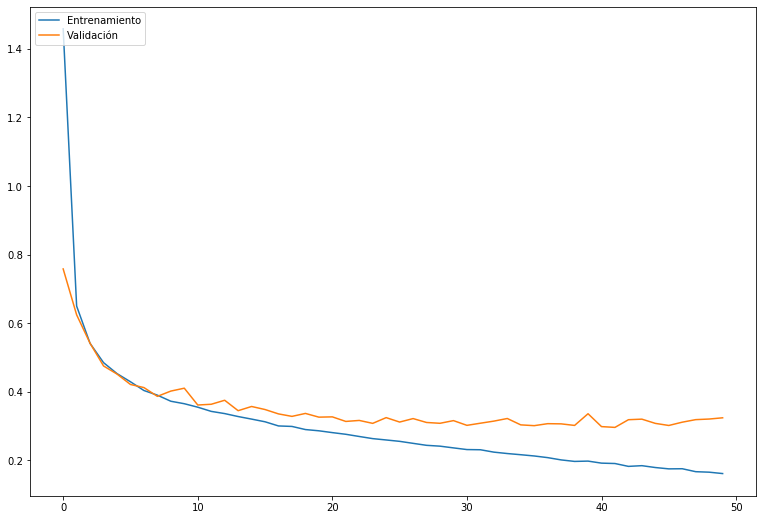

In [41]:
# Graficar los valores de pérdida en el entrenamiento
plt.figure(figsize=(13, 9))
plt.plot(historia_ruido_entrada.history['loss'])
plt.plot(historia_ruido_entrada.history['val_loss'])
plt.legend(["Entrenamiento", "Validación"], loc='upper left')
plt.show()

Después de 50 épocas de entrenamiento se puede ver como se ha mitigado el sobreajuste, o al menos se ha controlado en cierta forma. Esta es una de las formas más generales de reducir el sobreajuste, aunque no es muy común. Este método es más común como un tipo de _aumento de datos,_ que será discutido en otro documento.

In [42]:
modelo_ruido_entrada.evaluate(x_test, y_test)

10000/10000 [==============================] - 5s 547us/step


[0.3304824969172478, 0.8922]

La precisión de este modelo no es estado del arte, pero para ser una arquitectura muy simple, con solamente este tipo de regularización se ha desempeñado bastante bien.

## Regularización en las capas escondidas

En este modelo se emplea nuevamente descenso de gradiente estocástico con ratio de aprendizaje 0.001 y momento de 0.9.

In [43]:
modelo_ruido_capas.compile(loss="categorical_crossentropy",
                            optimizer=SGD(lr=0.001, momentum=0.9),
                            metrics=["accuracy"])
historia_ruido_capas = modelo_ruido_capas.fit(x_train, y_train, batch_size=batch_size,
                        validation_split=0.2,
                        epochs=epocas)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 152s 3ms/step - loss: 1.4141 - acc: 0.4885 - val_loss: 0.7554 - val_acc: 0.7142
Epoch 2/50
48000/48000 [==============================] - 133s 3ms/step - loss: 0.6914 - acc: 0.7447 - val_loss: 0.6085 - val_acc: 0.7794
Epoch 3/50
48000/48000 [==============================] - 133s 3ms/step - loss: 0.5831 - acc: 0.7882 - val_loss: 0.5528 - val_acc: 0.8003
Epoch 4/50
48000/48000 [==============================] - 133s 3ms/step - loss: 0.5241 - acc: 0.8092 - val_loss: 0.4996 - val_acc: 0.8181
Epoch 5/50
48000/48000 [==============================] - 133s 3ms/step - loss: 0.4804 - acc: 0.8270 - val_loss: 0.4835 - val_acc: 0.8243
Epoch 6/50
48000/48000 [==============================] - 134s 3ms/step - loss: 0.4466 - acc: 0.8396 - val_loss: 0.4678 - val_acc: 0.8331
Epoch 7/50
48000/48000 [==============================] - 134s 3ms/step - loss: 0.4302 - acc: 0.8455 - val_loss: 0.4595 - 

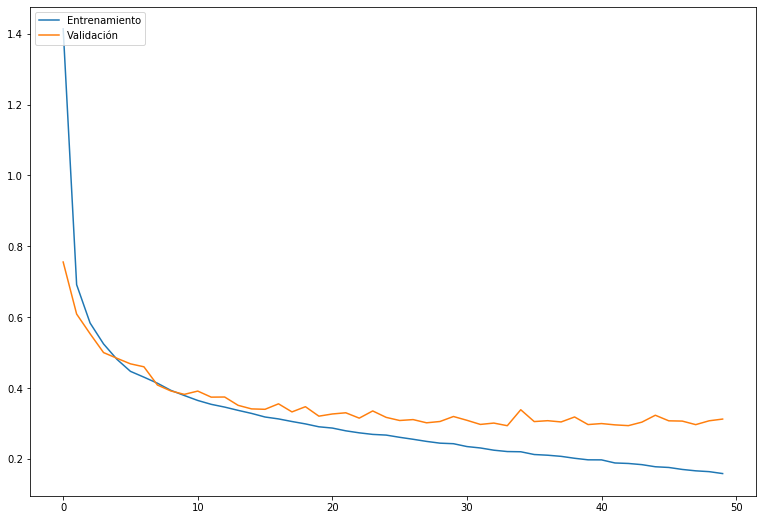

In [44]:
# Graficar los valores de pérdida en el entrenamiento
plt.figure(figsize=(13, 9))
plt.plot(historia_ruido_capas.history['loss'])
plt.plot(historia_ruido_capas.history['val_loss'])
plt.legend(["Entrenamiento", "Validación"], loc='upper left')
plt.show()

Este modelo tiene mayor susceptibilidad a ser sobreajustado. Es fácil de ver dado que las curvas comienzan a separarse en las últimas épocas de entrenamiento. Esto implica que introducir tanto ruido en la CNN no es conveniente.

In [45]:
modelo_ruido_capas.evaluate(x_test, y_test)

10000/10000 [==============================] - 5s 488us/step


[0.3290466861695051, 0.8905]

Como se ve, el resultado empeoró con el simple hecho de ingresar tanto ruido a la red neuronal.

## Dropout

Nuevamente, se emplea descenso de gradiente estocástico con ratio de aprendizaje de 0.001 y momento de 0.9.

In [46]:
modelo_dropout.compile(loss="categorical_crossentropy",
                            optimizer=SGD(lr=0.001, momentum=0.9),
                            metrics=["accuracy"])
historia_dropout = modelo_dropout.fit(x_train, y_train, batch_size=batch_size,
                        validation_split=0.2,
                        epochs=epocas)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 56s 1ms/step - loss: 1.8951 - acc: 0.2960 - val_loss: 0.9346 - val_acc: 0.6670
Epoch 2/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.9770 - acc: 0.6336 - val_loss: 0.7222 - val_acc: 0.7377
Epoch 3/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.7920 - acc: 0.7017 - val_loss: 0.6436 - val_acc: 0.7615
Epoch 4/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.7127 - acc: 0.7316 - val_loss: 0.5905 - val_acc: 0.7793
Epoch 5/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.6609 - acc: 0.7522 - val_loss: 0.5536 - val_acc: 0.7908
Epoch 6/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.6267 - acc: 0.7637 - val_loss: 0.5301 - val_acc: 0.8004
Epoch 7/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.5922 - acc: 0.7760 - val_loss: 0.5056 - val_acc

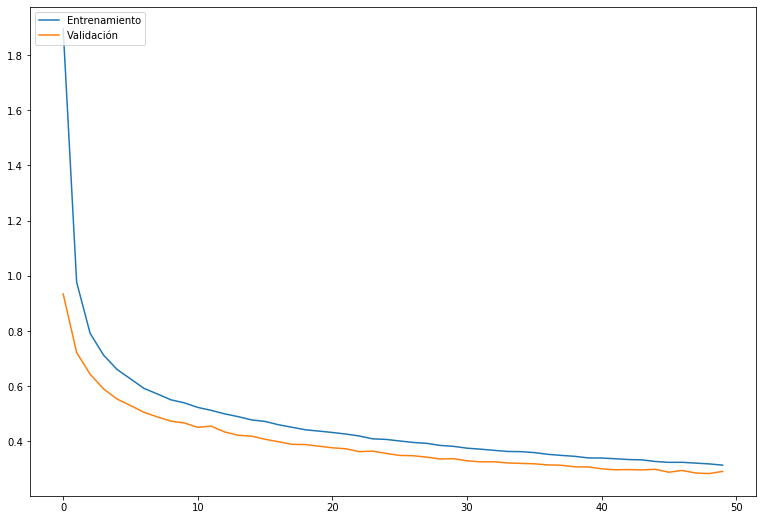

In [47]:
# Graficar los valores de pérdida en el entrenamiento
plt.figure(figsize=(13, 9))
plt.plot(historia_dropout.history['loss'])
plt.plot(historia_dropout.history['val_loss'])
plt.legend(["Entrenamiento", "Validación"], loc='upper left')
plt.show()

El sobreajuste es mínimo, casi imperceptible. El método de _dropout_ es simplemente robusto y excelente, además de rápido. La comparación con el modelo de ruido en cada capa escondida a este es sustancial: el tiempo es casi el doble, y el resultado es peor.

El método de _dropout_ sigue siendo una técnica clásica que se sigue utilizando con mucha frecuencia.

In [48]:
modelo_dropout.evaluate(x_test, y_test)

10000/10000 [==============================] - 4s 372us/step


[0.30559787740707395, 0.8882]

El resultado es mucho mejor que cualquiera de los otros modelos, el valor de la pérdida es menor y el valor de la precisión es adecuado, al menos se está casi seguro de que no hay tanto sobreajuste.

## Ejercicios

1. Probar combinando las diferentes técnicas mostradas aquí para obtener mejores resultados.